pere.pau.vazquez@upc.edu

https://medium.com/aiskunks/the-significance-of-distance-and-similarity-measures-in-clustering-bc9ec9292082

- crear github



In [29]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import dtreeviz
import umap
from scipy import stats
from scipy.stats import skew, kurtosis, ttest_ind
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.manifold import TSNE
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix, silhouette_samples, silhouette_score
from sklearn.tree import DecisionTreeClassifier
from skopt import BayesSearchCV
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, DBSCAN
from minisom import MiniSom

In [3]:
sns.set_theme(style="darkgrid", palette="pastel")
df = pd.read_csv("data\\case_df_op.csv")

# MÈTODES

## 1. Exploració inicial i anàlisi bàsic 

### 1.1. Descripció del conjunt de dades

In [19]:
print("-----INFO-----")
print(df.info())
print("-----ISNA-----")
print(df.isna().sum())
print("-----DUPLICATES-----")
print(df.duplicated().sum())

-----INFO-----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221919 entries, 0 to 221918
Columns: 670 entries, Unnamed: 0 to Stability
dtypes: float64(667), int64(2), object(1)
memory usage: 1.1+ GB
None
-----ISNA-----
Unnamed: 0         0
V1            199410
theta1        199410
V2            199410
theta2        199410
               ...  
P_GFOL31      217799
Q_GFOL31      217799
Sn_GFOL31     217799
case_id            0
Stability          0
Length: 670, dtype: int64
-----DUPLICATES-----
0


Observacions:
- Molts NaN
- No duplicats
- Columna Unnamed: 0 correspon al índex -> al carregar posar index_col=0
- Columna Case_id no és numèrica

In [ ]:
df.dropna(inplace=True)
df.drop("Unnamed: 0", axis=1, inplace=True)

### 1.2. Anàlisi variables

- Histograma            -> Veure si les dades segueixen alguna distribució o si hi ha variables que no aporten informació. 
- Boxplot/violinplot    -> Observar variança i detectar outliers. 

####

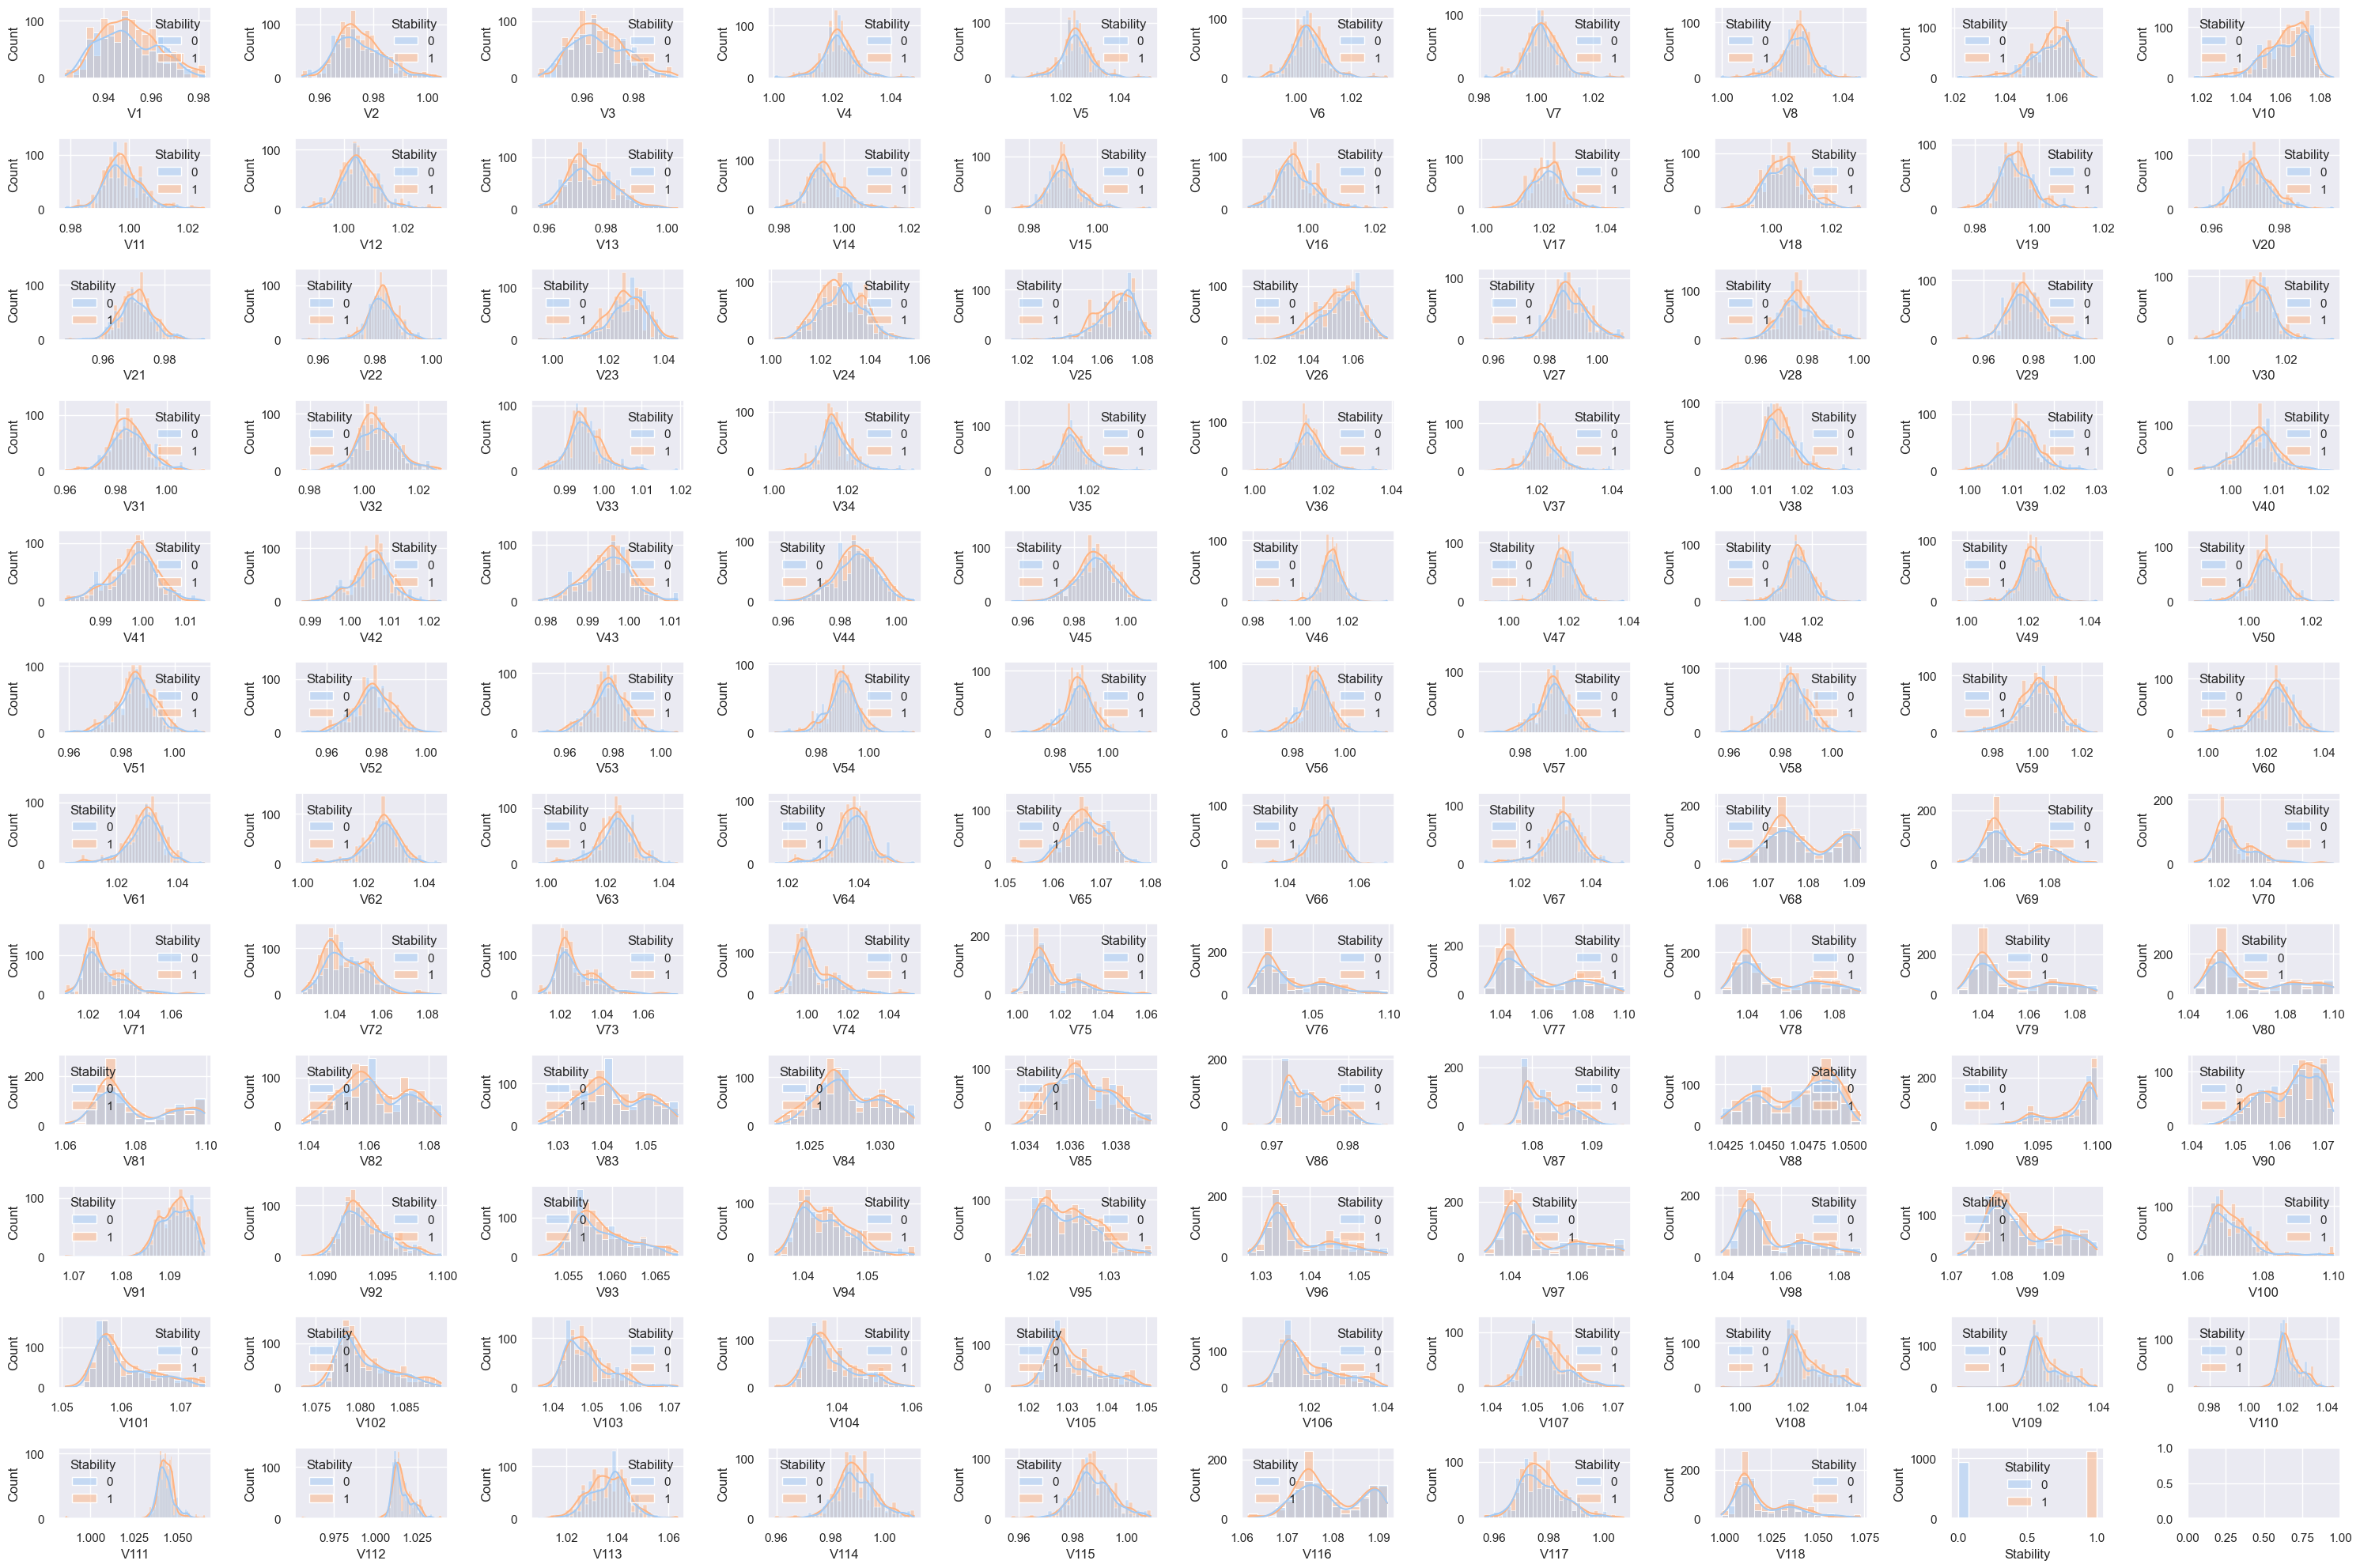

In [21]:
df_v = df.filter(regex='^V|Stability', axis=1)
df_theta = df.filter(regex='^theta|Stability', axis=1)
df_P = df.filter(regex='^P|Stability', axis=1)
df_Q = df.filter(regex='^Q|Stability', axis=1)
df_S = df.filter(regex='^S|Stability', axis=1)

fig, axes = plt.subplots(12, 10, figsize=(30, 20))
for i, col in enumerate(df_v.columns.to_list()):
    ax = axes.reshape(-1)[i]
    sns.histplot(data=df_v, x=col, hue="Stability", kde=True, ax=ax)
        
plt.tight_layout()
plt.show()


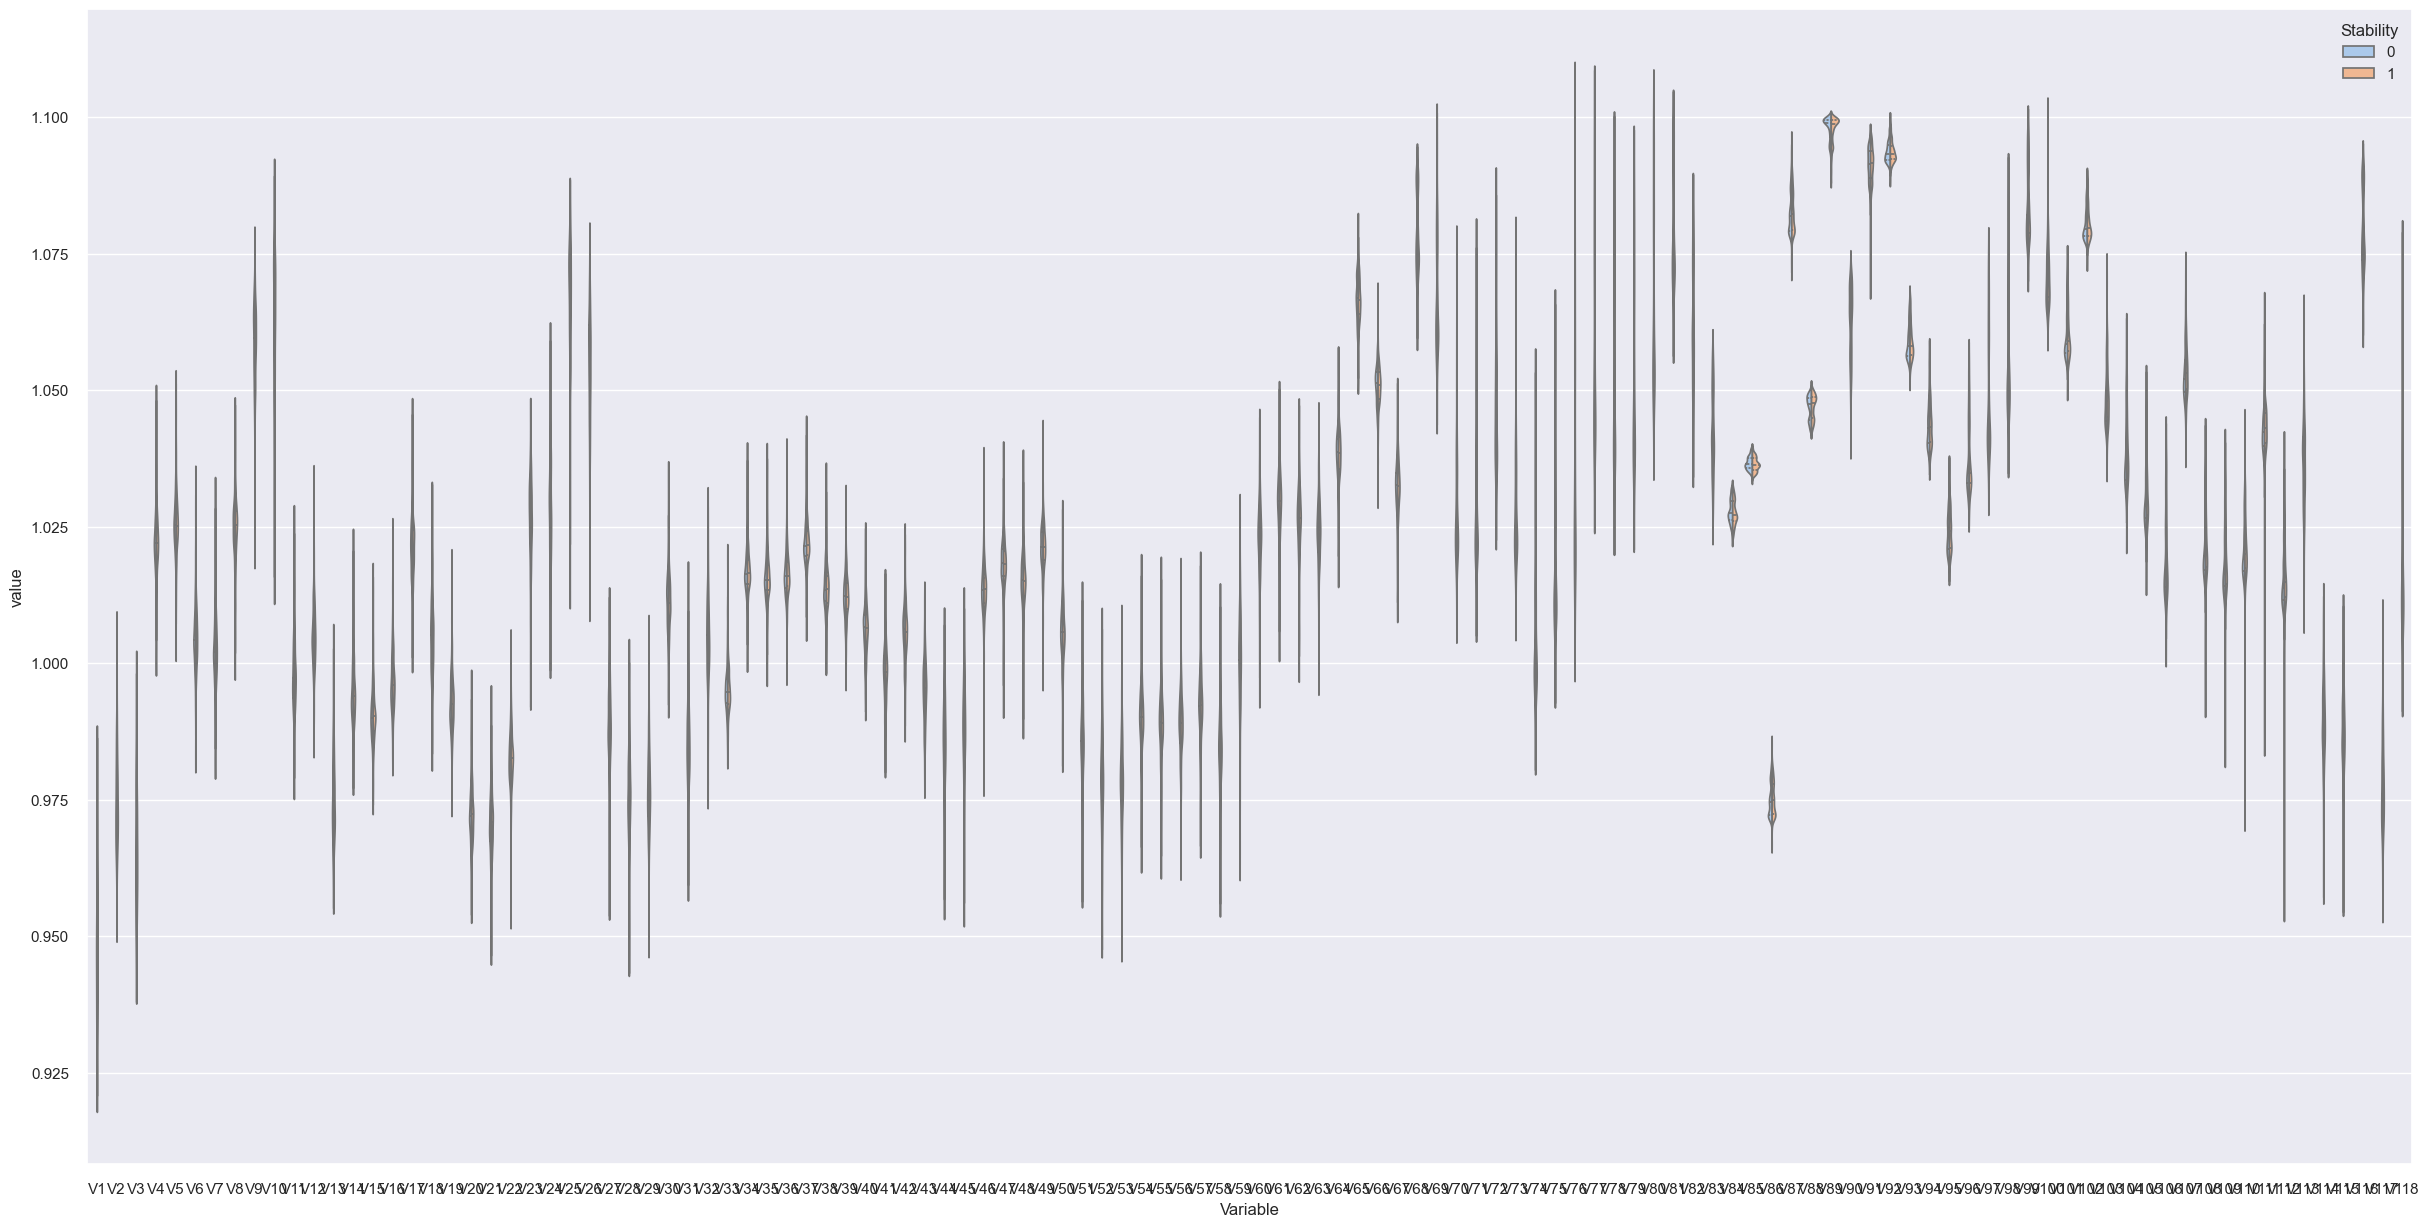

In [22]:
v_cols = df.filter(regex='^V', axis=1).columns.tolist()
df_melted = df.melt(id_vars=["Stability"], value_vars=v_cols, var_name="Variable", value_name="value")
plt.figure(figsize=(30, 15))
sns.violinplot(data=df_melted, x="Variable", y ="value", hue="Stability", split=True, inner="quart")
plt.show()


#### 

**Problema**: visualitzar cada variable per separat és inviable i totes de cop tampoc permet interpretar correctament. Buscar alguna manera de detectar outliers i distribucions sense visualitzar. 
<p align="left">
<img src="img/skew.png" alt="PCA plot" width="38%" style="float: right; margin-left: 100px; margin-right:100px;">
<img src="img/kurt.png" alt="PCA plot" width="38%" style="float: right; margin-left: 100px; margin-right:100px;">

- skewness: $skew=\frac{3(mean-median)}{σ}$ descriu com de simetrica és la distribució.
- kurtosis: $kurt= \frac{1}{n} \textstyle\sum_{i=1}^n (\frac{x_i-mean}{σ})^4 -3$ descriu si la distribució és més plana o més "punxeguda".

    Si skew o kurt són NaN podem eliminar les variables pq són constants. 

- Z-score: $z_i​=\frac{xi​−μ}{σ}$​ si $|z_i| > t$ llavors es considera outlier. 
</p>

#### 

In [23]:
num_cols = df.select_dtypes(include=np.number).columns.tolist()
z_scores = np.abs(stats.zscore(df[num_cols]))
threshold = 3.5 #llindars tipics 2 <= t <= 4 
outliers = (z_scores > threshold)
outliers_z_summary = outliers.sum().sort_values(ascending=False)
print(outliers_z_summary)


P_SG25       46
Q_SG85       43
Q_GFOL100    41
Q_GFOR15     40
V100         39
             ..
P_SG4         0
Sn_SG10       0
Q_SG10        0
P_SG10        0
Stability     0
Length: 668, dtype: int64


In [24]:
from scipy.stats import normaltest
from scipy.stats import skew, kurtosis

skewness = abs(df[num_cols].apply(skew))
kurt = df[num_cols].apply(kurtosis)

dist_summary = pd.DataFrame({'skewness': skewness, 'kurtosis': kurt})
dist_summary.sort_values(['skewness'], inplace=True)

print(dist_summary)


C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\apply.py:907: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  results[i] = self.f(v)


          skewness  kurtosis
P_SG55    0.005302 -0.594706
Q_SG26    0.007256 -0.544291
QL83      0.011834 -1.149856
QL58      0.011834 -1.149856
QL57      0.011834 -1.149856
...            ...       ...
Sn_SG105       NaN       NaN
Sn_SG19        NaN       NaN
Sn_SG70        NaN       NaN
Sn_SG72        NaN       NaN
Sn_SG24        NaN       NaN

[668 rows x 2 columns]


C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\apply.py:907: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  results[i] = self.f(v)


### 1.3 Comparació variables

- Correlació  -> Mesura la força i direcció de la relació.
- t-test      -> Es pot utilizar per mirar si el valor d’una variable té una diferencia significativa segons el grup al qual pertany (Estable, No estable).


####

<AxesSubplot:>

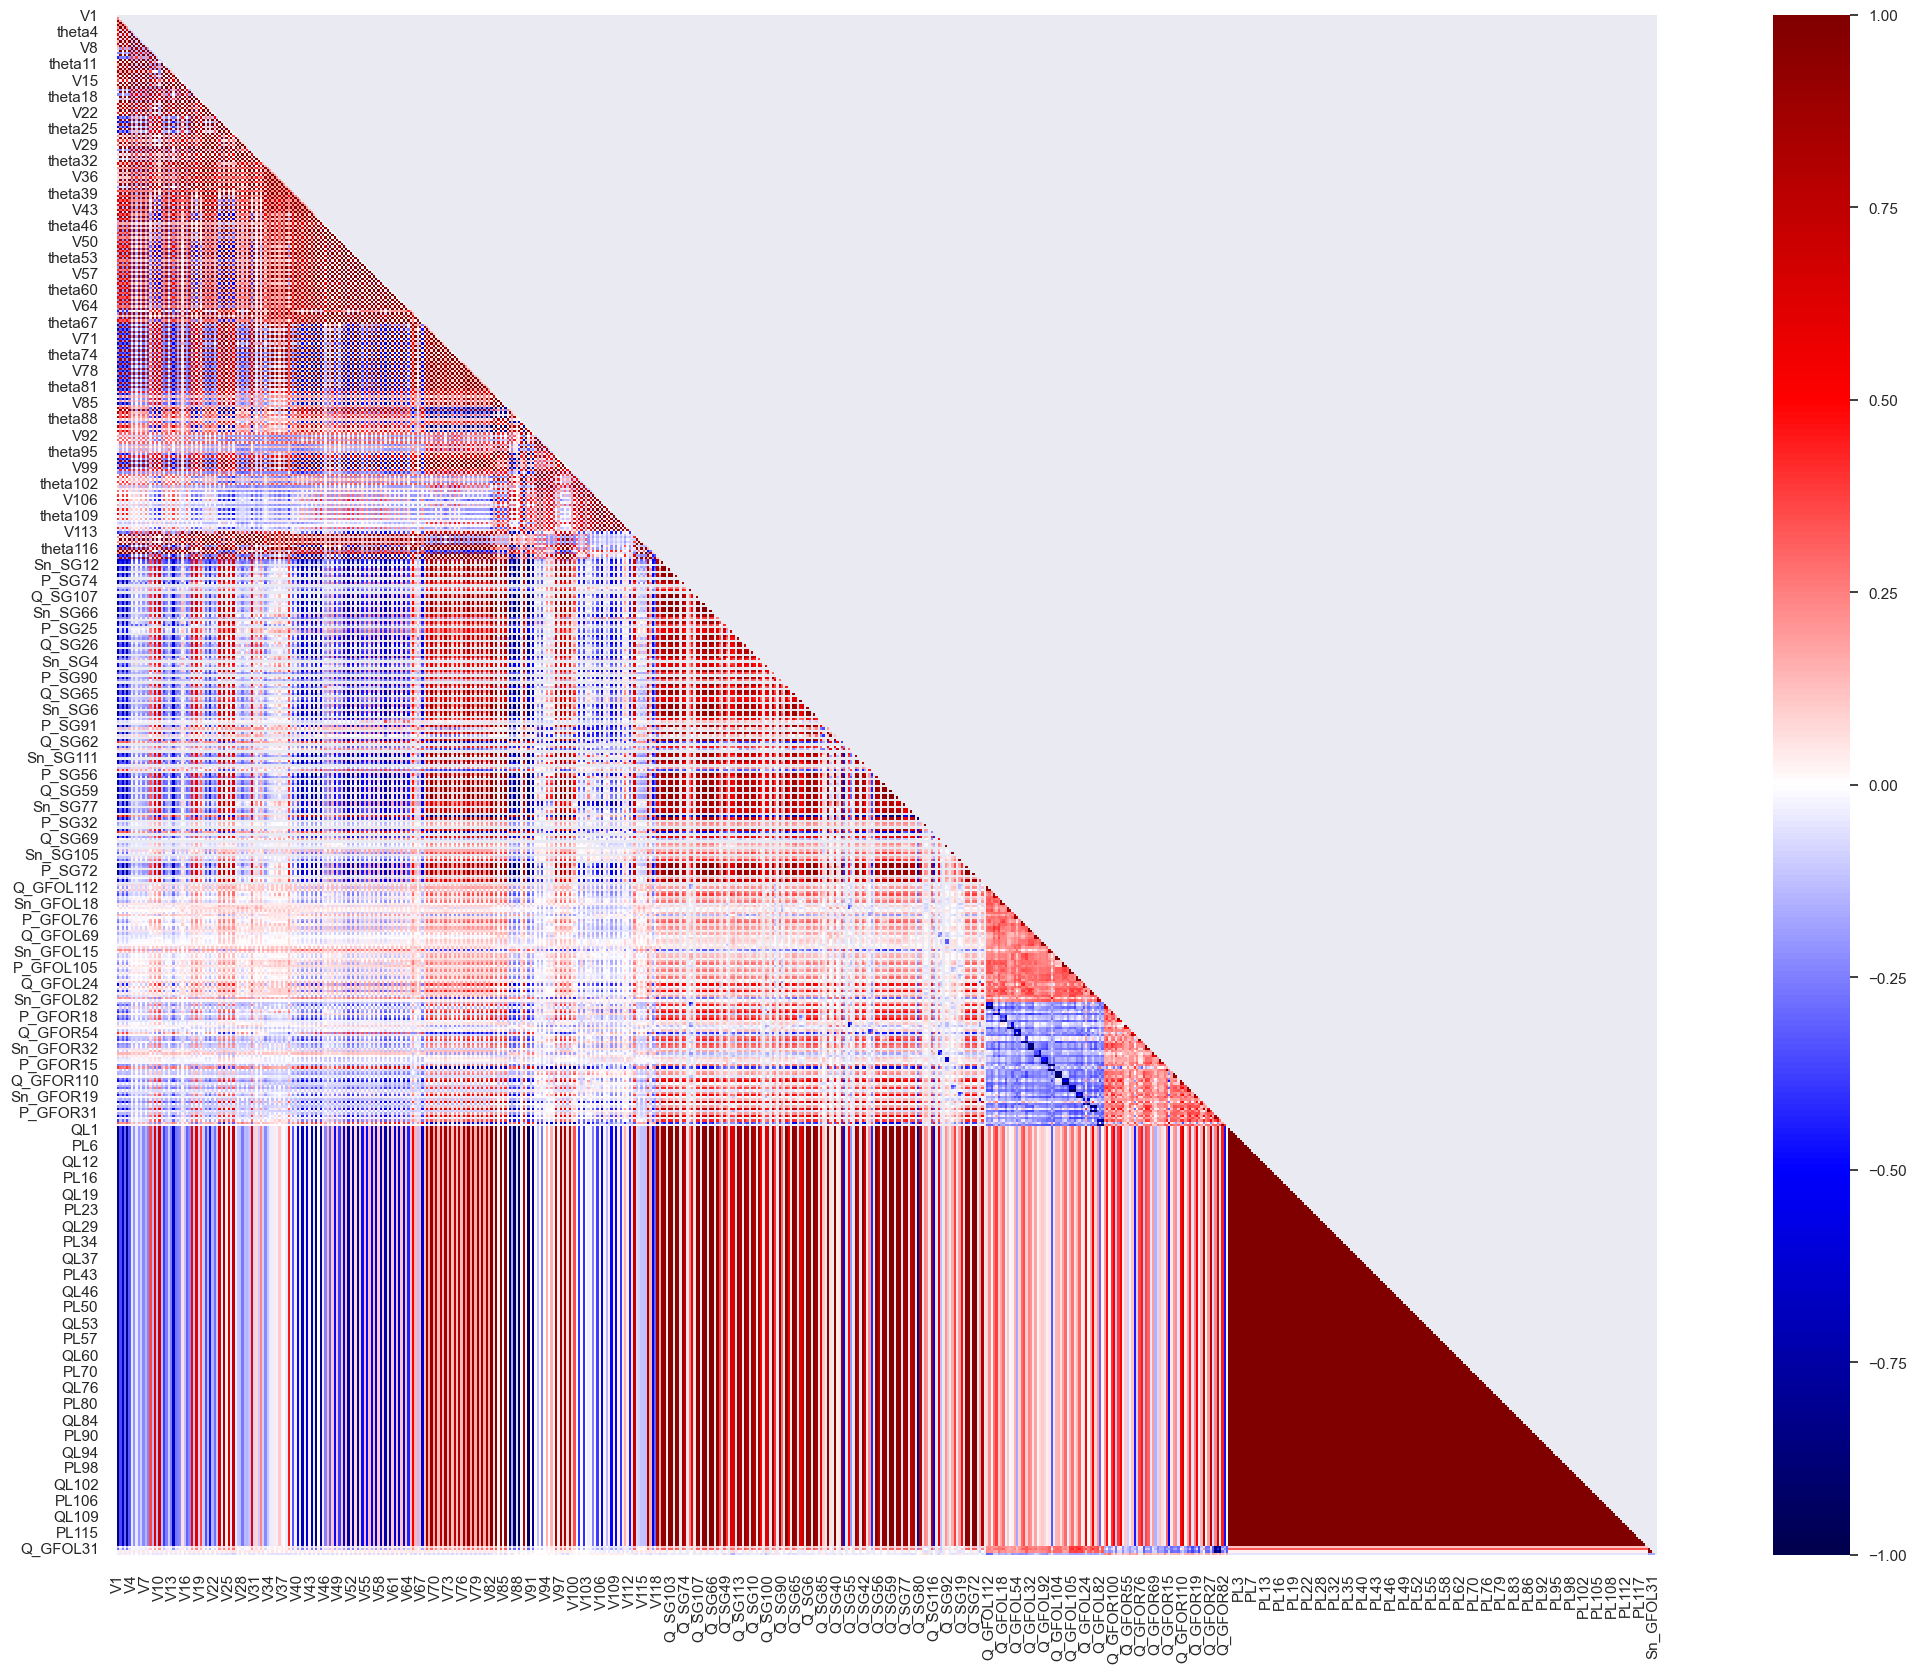

In [25]:
corr = df.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(30, 20))
sns.heatmap(corr, mask=mask, cmap='seismic',  center=0, square=True)

C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\yellowbrick\target\feature_correlation.py:174: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  [pearsonr(x, y, **kwargs)[0] for x in np.asarray(X).T]


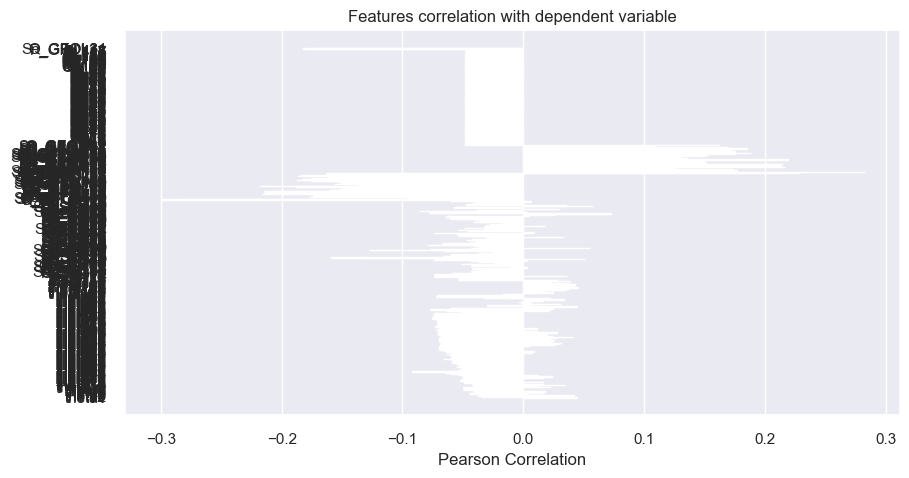

In [26]:
from yellowbrick.target.feature_correlation import feature_correlation
X_a = df[num_cols].drop(columns=['Stability'])
y_a = df['Stability']
plt.figure(figsize=(10,5))
visualizer = feature_correlation(X_a, y_a, labels=list(X_a.columns),method='pearson');

In [27]:
from scipy.stats import ttest_ind

t_stats = []
p_values = []
for col in num_cols:
    group1 = df[df['Stability'] == 0][col]
    group2 = df[df['Stability'] == 1][col]
    t_stat, p_value = ttest_ind(group1, group2, equal_var=False)
    t_stats.append(t_stat)
    p_values.append(abs(p_value))

res = pd.DataFrame({'t_stat': t_stats, 'p_value': p_values}, index=num_cols)
print(res)



C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


             t_stat       p_value
V1        -2.002775  4.533703e-02
theta1     1.590712  1.118292e-01
V2        -1.745123  8.111708e-02
theta2     1.736777  8.257724e-02
V3        -1.896969  5.797690e-02
...             ...           ...
QL118      2.175128  2.973756e-02
P_GFOL31   8.003865  2.133643e-15
Q_GFOL31   8.206447  4.428989e-16
Sn_GFOL31  7.714210  1.969482e-14
Stability      -inf  0.000000e+00

[668 rows x 2 columns]


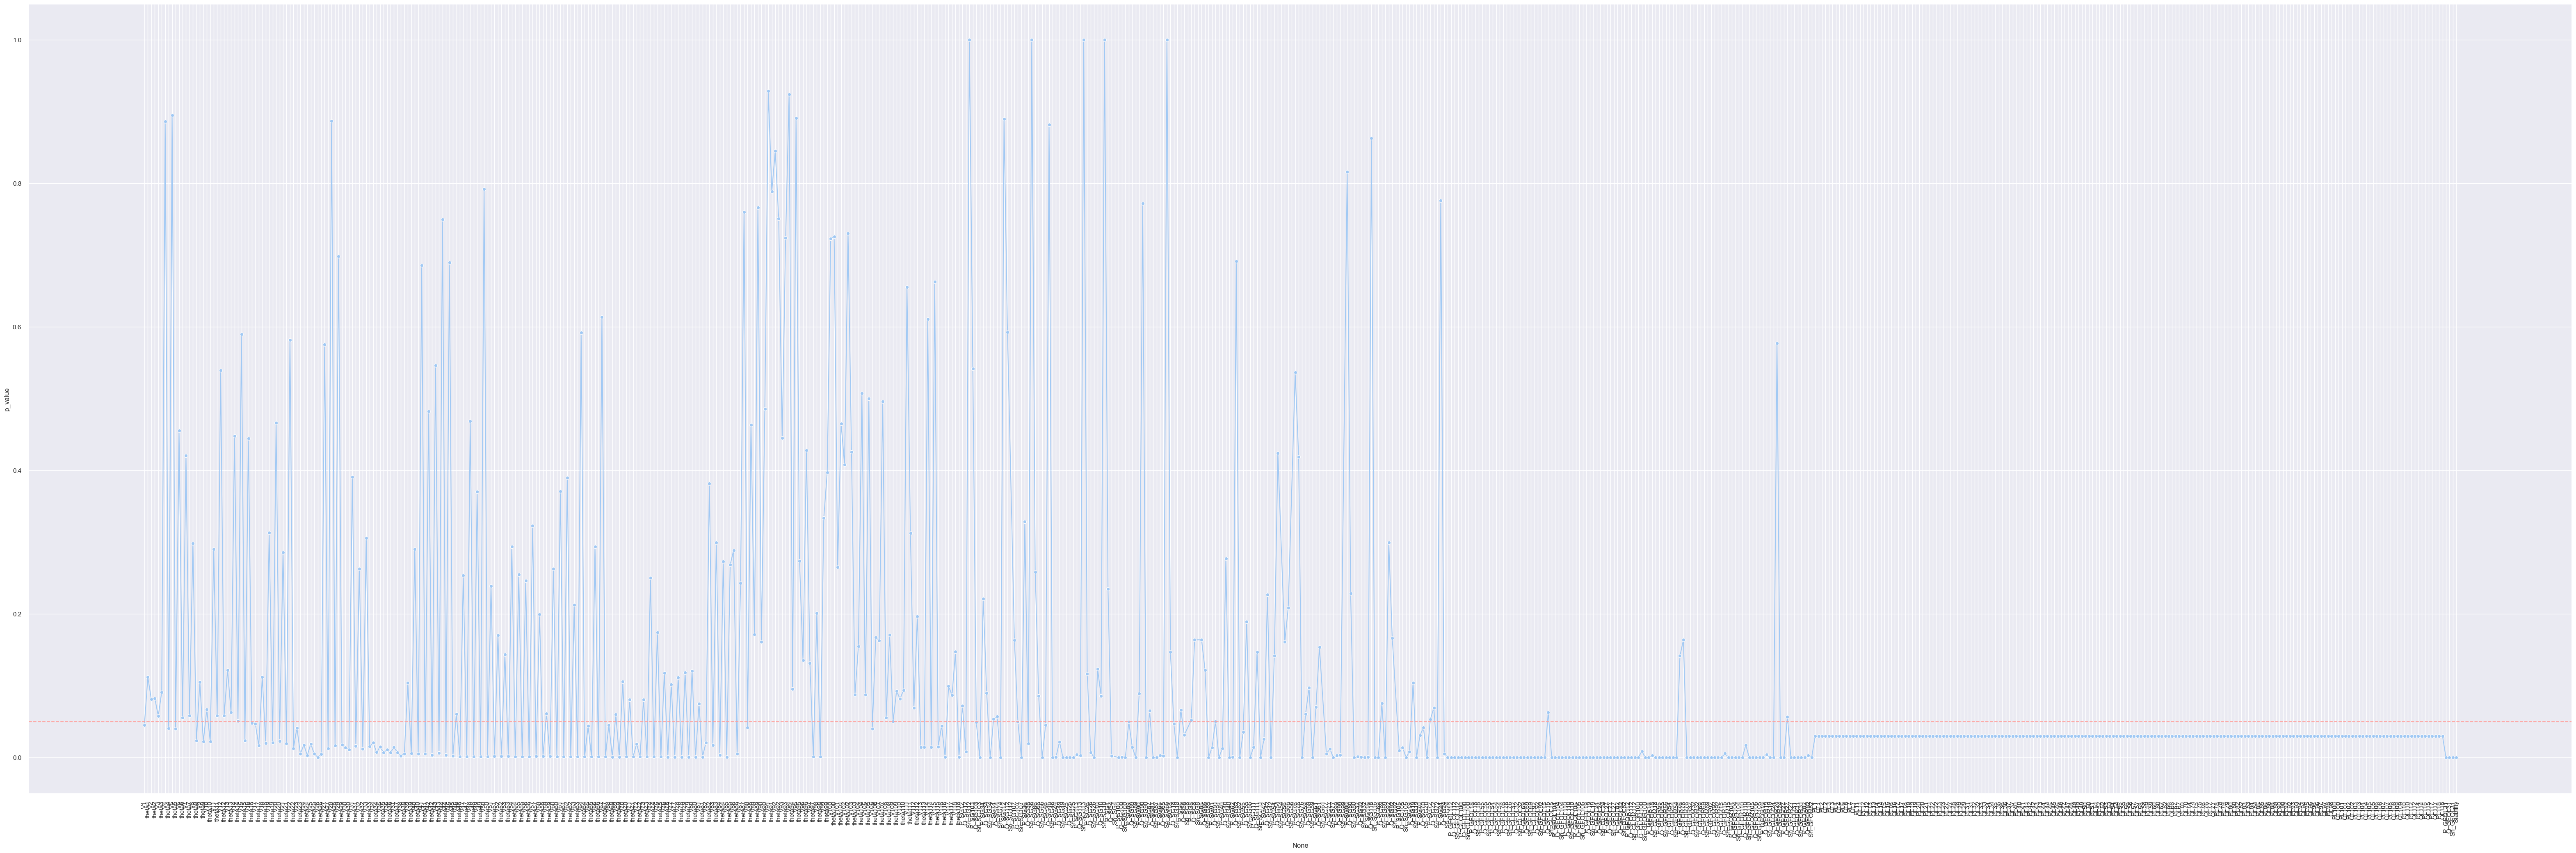

In [28]:
plt.figure(figsize=(80, 25))
sns.lineplot(data=res, x=res.index, y='p_value', marker='o')
plt.axhline(y=0.05, color='r', linestyle='--')
plt.xticks(rotation=90)
plt.show()

In [29]:
res = res.sort_values(by='p_value', ascending=False)
print(res)

          t_stat  p_value
Sn_SG113     0.0      1.0
Sn_SG12      0.0      1.0
Sn_SG10      0.0      1.0
Sn_SG36      0.0      1.0
Sn_SG65      0.0      1.0
...          ...      ...
Sn_SG54      NaN      NaN
Sn_SG56      NaN      NaN
Sn_SG61      NaN      NaN
Sn_SG99      NaN      NaN
Sn_SG92      NaN      NaN

[668 rows x 2 columns]


### Preprocessament (fine_df)

Després de veure aquest anàlisis de les dades procediré a obtenir un conjunt de dades que li dire *fine_df* en el qual s'eliminaràn totes es variables que s'han trobat que no aporten informació rellevant, són constants, etc.

Tot i tenir el conjunt *fine_df* mantindré el conjunt original per veure si relament la neteja de dades irrellevants suposa una ajuda a l'hora de treballar amb les dades o la perdua d'informació és important. 

In [14]:
fine_df = pd.read_csv("data\\case_df_op.csv", index_col=0)
fine_df.drop("case_id", axis=1, inplace=True)
fine_df.dropna(subset=[col for col in fine_df.columns if col != "Stability"], how= 'all', inplace=True)
fine_df.fillna(0, inplace=True)
fine_df.shape

(22509, 668)

#### 1. Eliminar constants

Previament s'ha vist que totes les variables Sn_SGX són constants i per tant es poden eliminar.

In [15]:
sn_sgx = df.filter(regex='^Sn_SG', axis=1).columns.tolist()
fine_df.drop(columns=sn_sgx, inplace=True)
fine_num_cols = fine_df.select_dtypes(include=np.number).columns.tolist()
fine_df = fine_df[fine_num_cols]

X = fine_df.drop(columns=['Stability'])
y = fine_df['Stability']

#### 2. Transformar segons skewness i kurtosis

Segons el valor de skewness i kurtosis podem:

| Mètrica  | Valor (abs)   | Què indica                         | Possible acció                 |    
| -------- | ------------- | ---------------------------------- | ------------------------------ | 
| Skewness | < 1           | Simetria                           |                                |    
|          | 1–2           | Asimetria moderada                 |                                |    
|          | >2            | Asimetria forta                    | Transformar                    |    
| Kurtosis | 2–4           | Normal                             |                                |   
|          | >7            | Molta concentració o cues llargues | Transformar / revisar outliers |   




In [16]:
skewness = abs(X.apply(skew))
kurt = X.apply(kurtosis)

dist_summary = pd.DataFrame({'skewness': skewness, 'kurtosis': kurt})
dist_summary.sort_values(['skewness'], inplace=True)
cols_to_transform = dist_summary[dist_summary['skewness'] > 2].index.tolist()
print(dist_summary)
print(cols_to_transform)

            skewness     kurtosis
V34         0.000462     1.698356
V27         0.000820     1.687858
V22         0.010784     1.661986
P_GFOR104   0.010990    -1.333154
V29         0.014519     1.654311
...              ...          ...
theta65    25.526617   755.109093
theta70    26.053164   777.410821
theta66    27.009571   871.359045
theta50    28.192066   961.020486
theta49    30.345697  1202.845146

[620 rows x 2 columns]
['Q_SG99', 'P_GFOL76', 'Q_GFOL15', 'Q_GFOR15', 'Q_GFOR82', 'P_SG74', 'Q_SG42', 'Q_GFOR76', 'Q_SG32', 'P_SG32', 'theta41', 'theta40', 'Q_GFOL76', 'Sn_GFOL31', 'Q_SG116', 'Q_SG111', 'P_GFOL31', 'theta43', 'theta39', 'theta24', 'theta38', 'theta36', 'P_SG80', 'theta35', 'theta37', 'theta34', 'P_SG25', 'Q_GFOL31', 'P_SG99', 'theta1', 'theta23', 'Q_SG56', 'theta3', 'theta26', 'theta117', 'theta25', 'theta2', 'theta30', 'theta33', 'theta31', 'theta32', 'theta113', 'theta13', 'theta29', 'theta12', 'theta18', 'theta11', 'theta27', 'theta28', 'theta114', 'theta22', 'thet

In [17]:
pt = PowerTransformer(method='yeo-johnson', standardize=False)

X_norm = X.copy()

X_norm[cols_to_transform] = pt.fit_transform(X[cols_to_transform])

skewness = abs(X_norm.apply(skew))
kurt = X_norm.apply(kurtosis)

dist_summary = pd.DataFrame({'skewness': skewness, 'kurtosis': kurt})
dist_summary.sort_values(['skewness'], inplace=True)

print(dist_summary)

          skewness    kurtosis
V34       0.000462    1.698356
V27       0.000820    1.687858
theta3    0.000890    0.024632
theta26   0.003052    4.702707
Q_SG111   0.009635    0.285887
...            ...         ...
theta101  2.561417   14.256579
theta103  2.565505   14.524918
theta88   2.567595   15.565796
theta100  2.570416   14.769187
theta87   7.548568  121.838186

[620 rows x 2 columns]


#### 3. Eliminar outliers

In [19]:

z_scores = np.abs(stats.zscore(X_norm))
threshold = 4
outliers = (z_scores > threshold)
outliers_z_summary = outliers.sum().sort_values(ascending=False)
print(outliers_z_summary)


theta85      777
theta18      605
theta38      603
theta33      596
theta34      596
            ... 
P_GFOL82       0
Sn_GFOL27      0
P_GFOL27       0
Sn_GFOL24      0
Sn_GFOL31      0
Length: 620, dtype: int64


In [20]:
X_clean = X_norm[(z_scores < threshold).all(axis=1)]
y_clean = y[(z_scores < threshold).all(axis=1)]

#### 4. Eliminar segons t-test

Ja que no vull destruir massa informació utilitzaré un llindar de p_value de 0.2 pel t-test per tenir cert marge dintre 

In [21]:
p_thresh = 0.2
t_stats = []
p_values = []
for col in X_clean.columns:
    group1 = X_clean[y_clean == 0][col]
    group2 = X_clean[y_clean == 1][col]
    t_stat, p_value = ttest_ind(group1, group2, equal_var=False)
    t_stats.append(t_stat)
    p_values.append(abs(p_value))

res = pd.DataFrame({'t_stat': t_stats, 'p_value': p_values}, index=X_clean.columns)
print(res.sort_values(by='p_value', ascending=False))
select_res = res[res['p_value'] < p_thresh].index.tolist()
print(len(select_res))

               t_stat   p_value
V19         -0.005010  0.996003
theta111     0.150947  0.880019
V32          0.182385  0.855282
theta28      0.214438  0.830208
V9           0.856919  0.391501
...               ...       ...
Sn_GFOR112 -66.844392  0.000000
Sn_GFOL69   39.127010  0.000000
Sn_GFOR18  -40.734982  0.000000
P_GFOL69    38.460690  0.000000
Sn_GFOR55  -39.626715  0.000000

[620 rows x 2 columns]
609


In [22]:
X_final = X_clean[select_res]
X_final.shape

(18308, 609)

#### 5. Escalar les dades

In [23]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_final)
y_scaled = y_clean.copy()

## 2. PCA – Principal Component Analysis

<p align="left">
<img src="img/pca.png" alt="PCA plot" width="38%" style="float: right; margin-left: 100px; margin-right:100px;">
Permet trobar i visualitzar les direccions demàxima variància de les dades.
Objectius:

- Reduir dimensionalitat
- Veure l’estructura global (eixos principals) de les dades

Limitacions:

- Assumeix relació lineal 
- Sensible a outlaiers
- Necessita normalització
- Poca interpretablititat quan hi ha masses components principals

Alternatives: Kernel PCA i Sparse KPCA
</p>

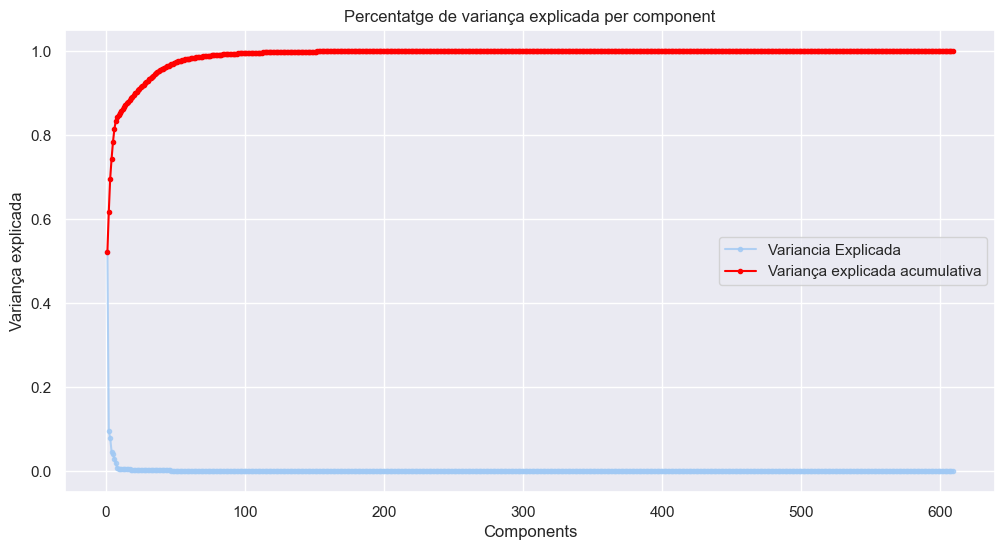

In [24]:
from sklearn.decomposition import PCA
pca = PCA().fit(X_scaled)
fig = plt.figure(figsize=(12,6));
plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),pca.explained_variance_ratio_ ,alpha=0.8,marker='.',label="Variancia Explicada");
y_label = plt.ylabel('Variança explicada');
x_label = plt.xlabel('Components');
plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),
         np.cumsum(pca.explained_variance_ratio_),
         c='red',marker='.',
         label="Variança explicada acumulativa");
plt.legend();
plt.title('Percentatge de variança explicada per component');

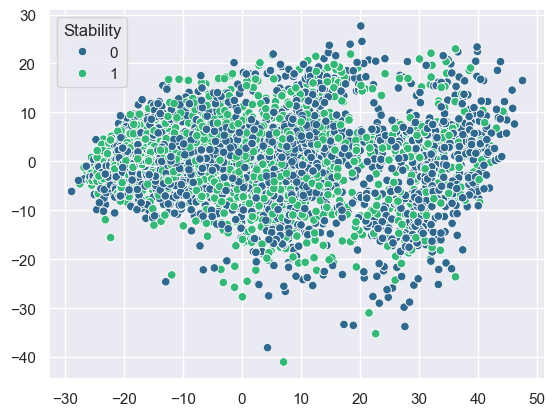

In [25]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

X_pca = pca.transform(X_scaled)
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y_scaled, palette='viridis');


In [26]:
X_pca = PCA(n_components=50).fit_transform(X_scaled)

## 3. t-SNE – t-distributed Stochastic Neighbor Embedding


<p align="left">
<img src="img/tsne.png" alt="PCA plot" width="35%" style="float: right; margin-left: 100px; margin-right:100px;">
Consisteix en convertir les “similituds” dels punts en un espai de probabilitats i llavors trobar una configuració de dimensionalitat reduïda que reprodueixi el mateix espai.

Objectius:

- Veure si les dades son separables (clústers)

Limitacions:

- Cost
- Fixar seed per reproductibilitat
- No preserva l'estructura
- Resultats no detarministes, seed diferent => resultats diferents
- Problemes amb moltes variables (aplicar primer reducció de dimensionalitat)

Alternatives: Barnes-Hut i Fit t-SNE
</p>

C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  File "C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


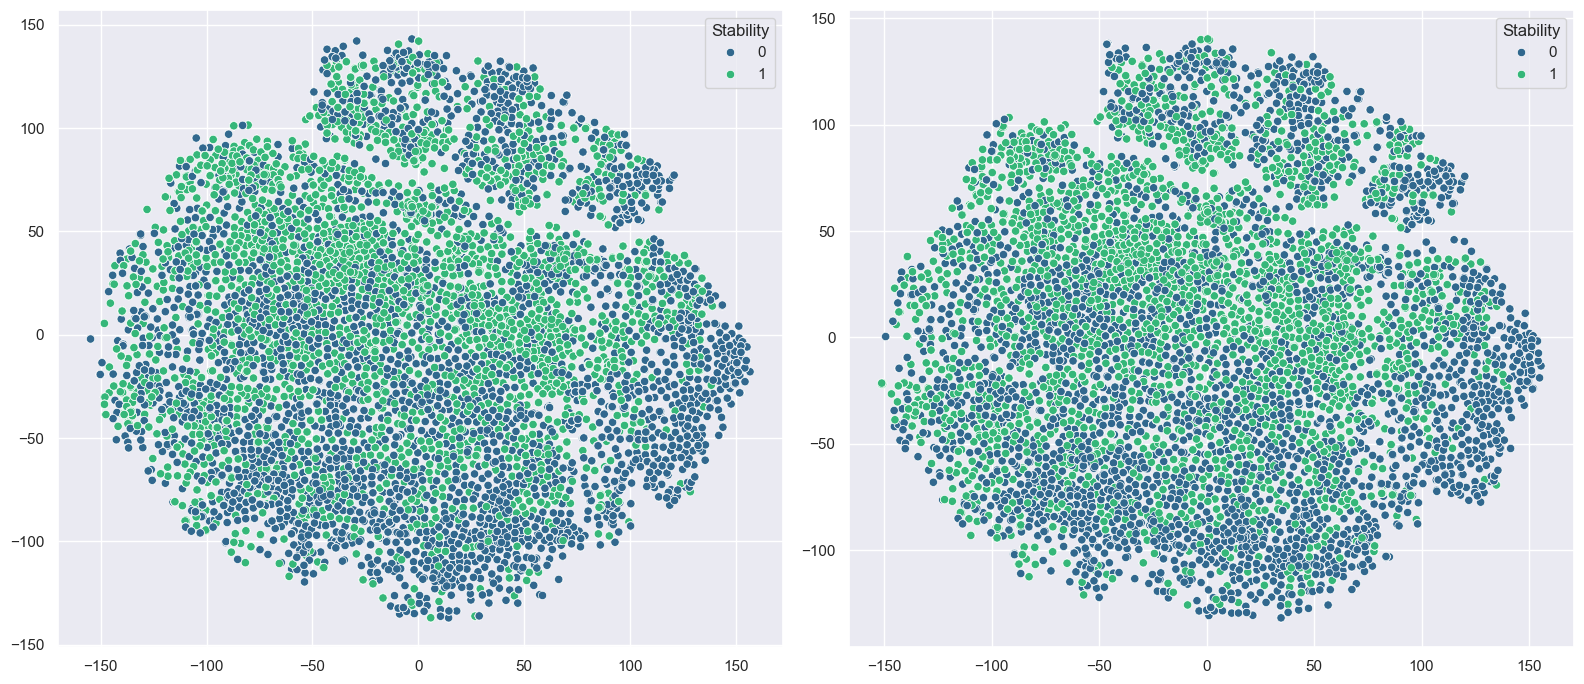

In [27]:
tsne = TSNE(random_state=42).fit_transform(X_scaled)
tsne_pca = TSNE(random_state=42).fit_transform(X_pca)
fig, ax = plt.subplots(1,2,figsize=(16,7))
sns.scatterplot(x=tsne[:,0], y=tsne[:,1], hue=y_scaled, palette="viridis", ax=ax[0]);
sns.scatterplot(x=tsne_pca[:,0], y=tsne_pca[:,1], hue=y_scaled, palette="viridis", ax=ax[1]);
plt.tight_layout()
plt.show();


## 4. UMAP – Uniform Manifold Approximation and Projection


<p align="left">
<img src="img/umap.png" alt="PCA plot" width="25%" style="float: right; margin-left: 100px; margin-right:100px;">
Busca un resultat similar a t-SNE però amb una aproximació diferent. Manté més bé la topologia original de les dades 

Objectius:

- Veure si les dades son separables (clústers)

Limitacions:

- Sensible als hiperparàmetres
- Reconstrucció complicada
- Resultats no deterministes, seed diferent => resultats diferents
- Millor preservació de l'estructura que t-sne, però seguix podent variar
- Problemes amb moltes variables (aplicar primer reducció de dimensionalitat)

</p>



C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\manifold\_spectral_embedding.py:455: UserWarning: Exited at iteration 160 with accuracies 
[5.50437779e-13 7.44220537e-06 4.29947503e-06 2.37229794e-06]
not reaching the requested tolerance 2.4884939193725586e-06.
Use iteration 160 instead with accuracy 
3.5284947209762526e-06.

C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\manifold\_spectral_embedding.py:455: UserWarning: Exited postprocessing with accuracies 
[8.06044481e-15 7.44220538e-06 4.29947497e-06 2.37229803e-06]
not reaching the r

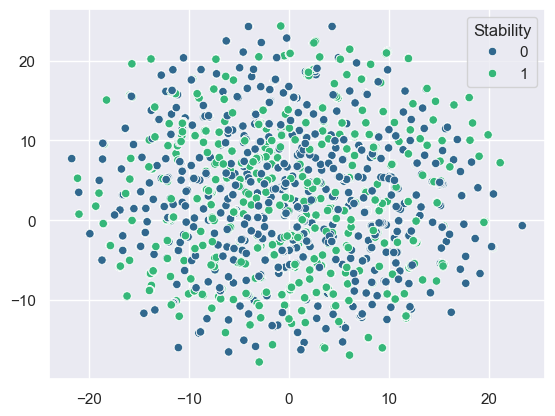

In [28]:

reducer = umap.UMAP(
    n_components=2, n_neighbors=15, random_state=42, transform_seed=42, verbose=False
);
reducer.fit(X_scaled);
embedding = reducer.transform(X_scaled);
sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=y_scaled, palette="viridis");



## 5. K-Means

<p align="left">
<img src="img/kmeans.png" alt="PCA plot" width="40%" style="float: right; margin-left: 100px; margin-right:100px;">

Intenta dividir les dades en k clústers.

Objectius:

- Veure si es poden dividir les dades en estable o no estable

Limitacions:

- Cal especificar k prèviament.
- Sensible a outliers
- Intenta crear clústers de mida similar (s'han de balancejar les dades).
- Només detecta clústers de forma esferoidal
- Resultats no deterministes, seed diferent => resultats diferents

Silouete method i elbow

</p>


For n_clusters = 2, silhouette_score = 0.32501091102939084


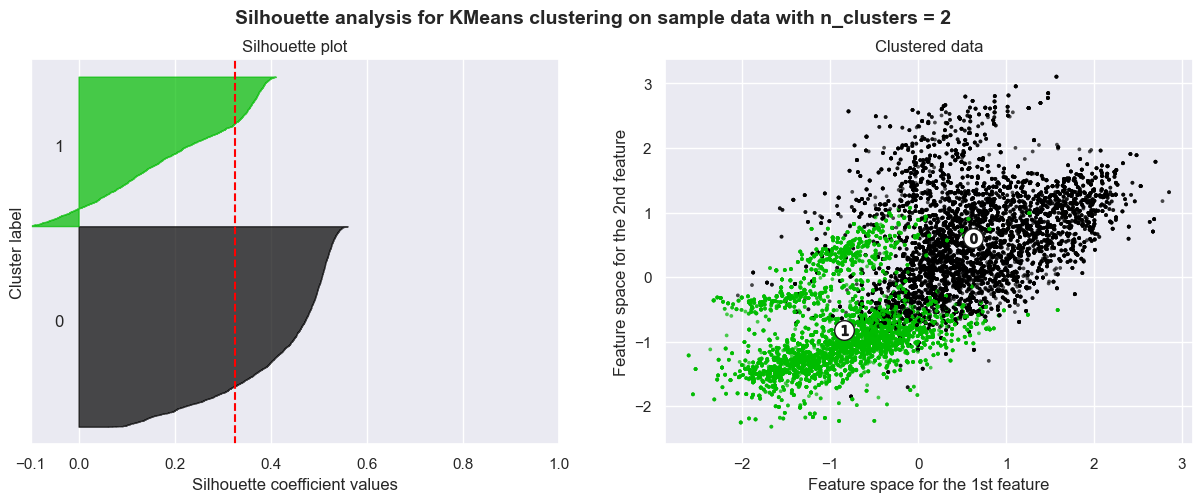

For n_clusters = 3, silhouette_score = 0.2518735214502387


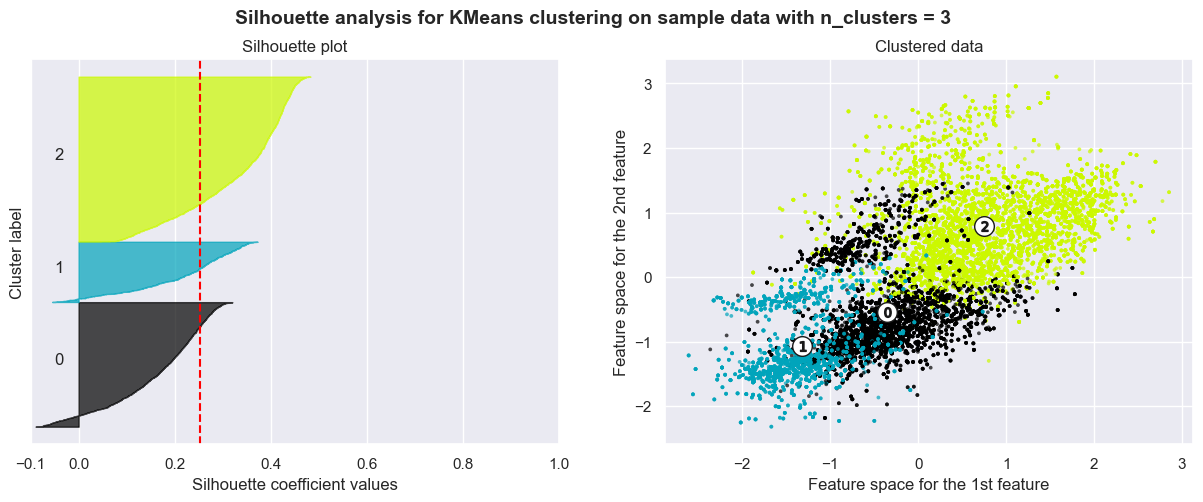

For n_clusters = 4, silhouette_score = 0.24058415459795013


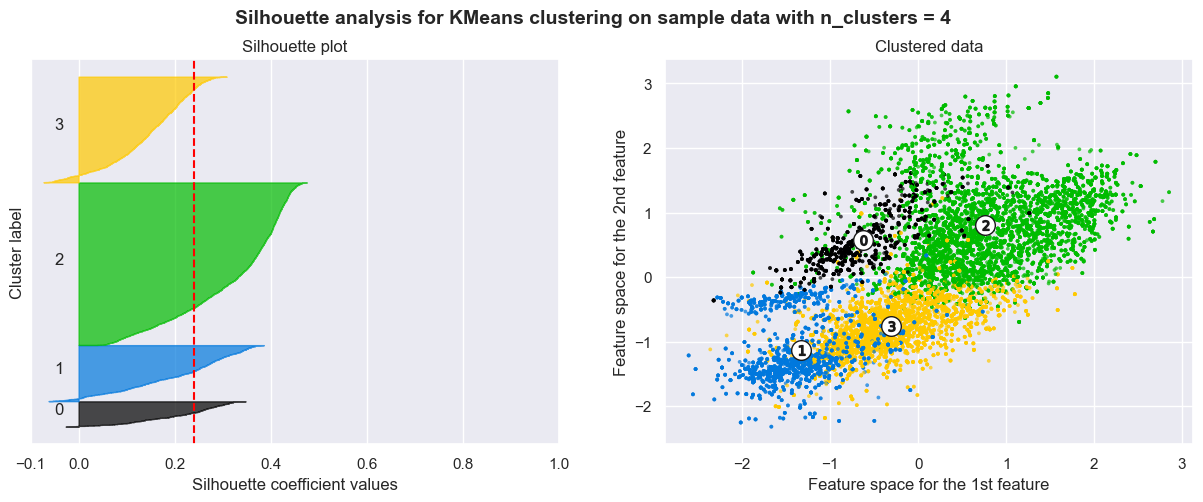

For n_clusters = 5, silhouette_score = 0.1502068754438975


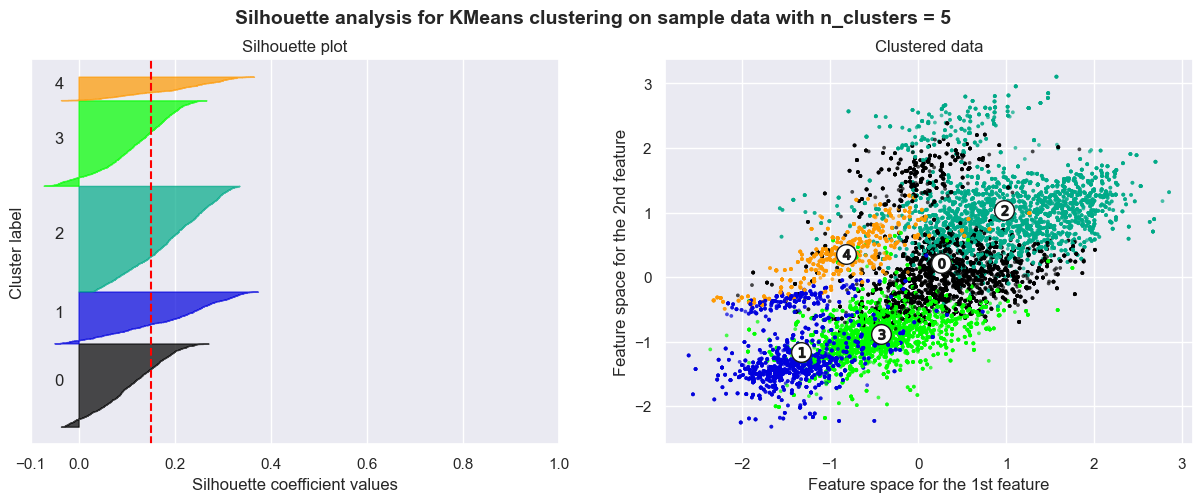

For n_clusters = 6, silhouette_score = 0.12864362176534846


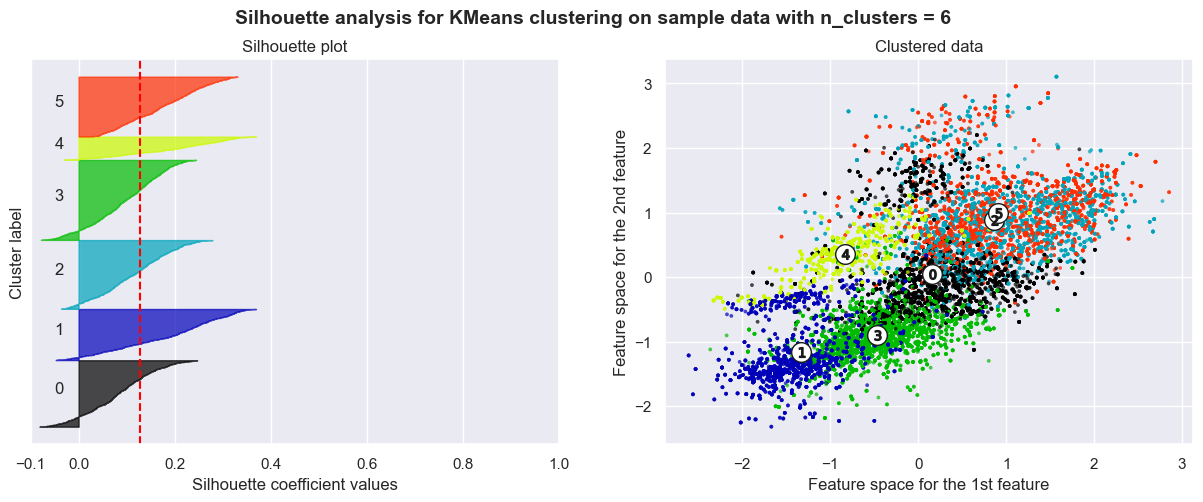

For n_clusters = 7, silhouette_score = 0.13739696025072823


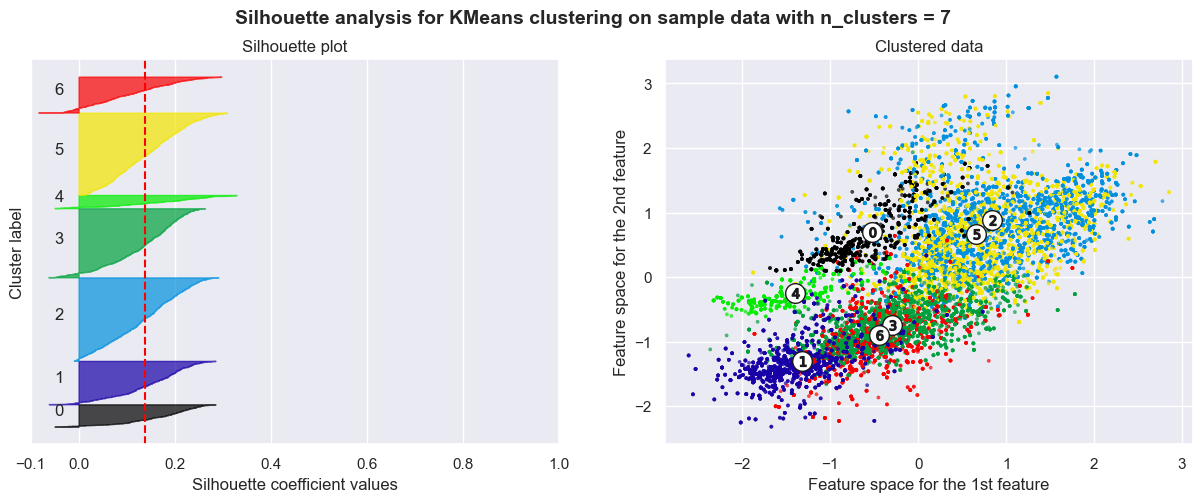

For n_clusters = 8, silhouette_score = 0.1364297073709981


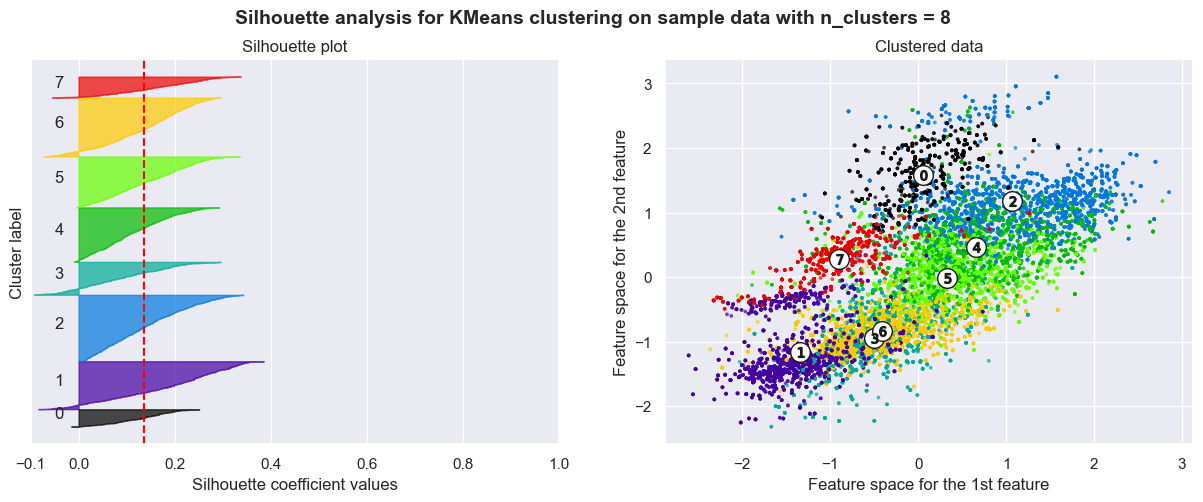

For n_clusters = 9, silhouette_score = 0.1290965012210097


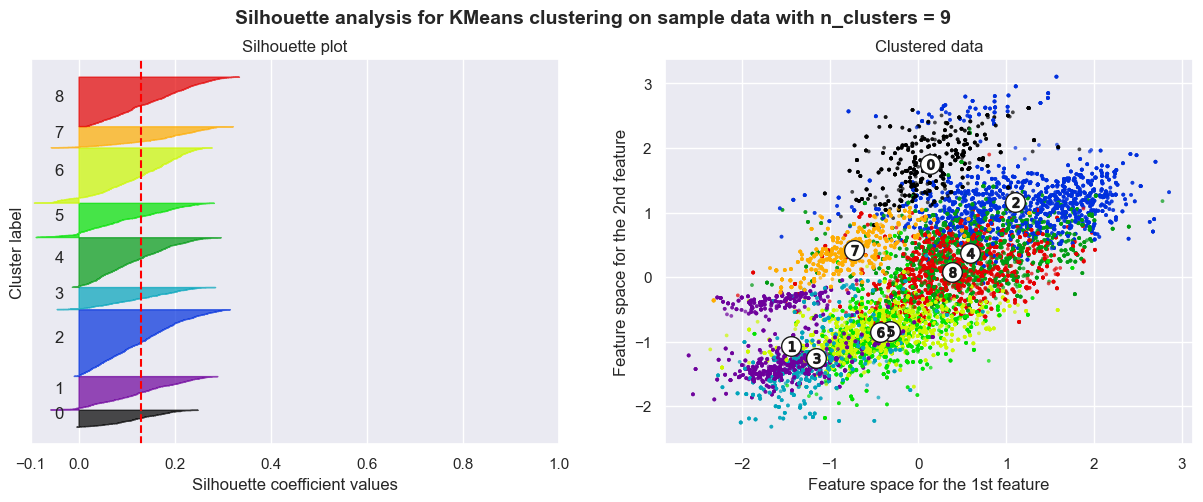

In [33]:
range_clusters = range(2, 10)
for n_clusters in range_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.set_xlim(-0.1, 1)
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    clusterer_labels = clusterer.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, clusterer_labels)
    print(
        f"For n_clusters = {n_clusters}, silhouette_score = {silhouette_avg}"
    )
    sample_silhouette_values = silhouette_samples(X_scaled, clusterer_labels)
    y_lower = 10

    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[clusterer_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
    
    ax1.set_title("Silhouette plot")
    ax1.set_xlabel("Silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    colors = plt.cm.nipy_spectral(clusterer_labels.astype(float) / n_clusters)
    ax2.scatter(
        X_scaled[:, 0],
        X_scaled[:, 1],
        marker=".",
        s=30,
        lw=0,
        alpha=0.7,
        c=colors,
        edgecolor="k",
    )
    centers = clusterer.cluster_centers_
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(
            c[0],
            c[1],
            marker="$%d$" % i,
            alpha=1,
            s=50,
            edgecolor="k",
        )
    ax2.set_title("Clustered data")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")
    plt.suptitle(
        f"Silhouette analysis for KMeans clustering on sample data with n_clusters = {n_clusters}",
        fontsize=14,
        fontweight="bold",
    )
    plt.show()

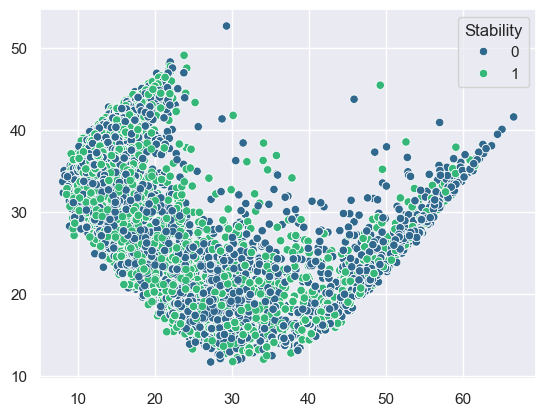

In [34]:

knn = KMeans(n_clusters=2, random_state=42).fit_transform(X_pca)
sns.scatterplot(x=knn[:,0], y=knn[:,1], hue=y_scaled, palette="viridis");


## 6. DBSCAN - Density-Based Spatial Clustering of Applications with Noise 

<p align="left">
<img src="img/dbscan.png" alt="PCA plot" width="35%" style="float: right; margin-left: 100px; margin-right:100px;">

Similar a k-Means, però agrupa punts que estan densament connectats i marca com a soroll aquells que no pertanyen a cap clúster.

Objectius:

- Veure si es poden dividir les dades en estable o no estable
- Detectar soroll i outliers

Limitacions:

- Sensible als hiperparàmetres
- Dificultat per adaptar-se a densitats molt variables
- Cost

</p>

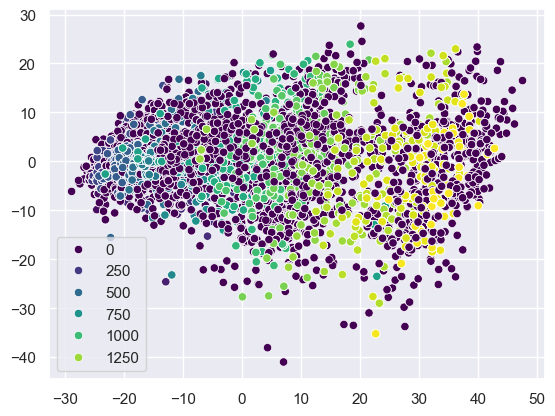

In [35]:
dbscan = DBSCAN(eps=3, min_samples=5).fit_predict(X_pca)
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=dbscan, palette="viridis");

## 7. SOM – Self-Organizing Map


<p align="left">
<img src="img/som.png" alt="PCA plot" width="40%" style="float: right; margin-left: 100px; margin-right:100px;">

Projecta dades d’alta dimensió en una graella bidimensional mantenint relacions topològiques.

(Mètode que menys conec i que de moment he posat per simple curiositat)

Objectius:

- Visualitzar i reduir la dimensionalitat de dades complexes
- Detectar patrons i similituds

Limitacions:

- Resultats dependents de la inicialització i mida de la graella.
- Cal ajustar molts hiperparàmetres
- Pot perdre informació si les dades són molt complexes.
</p>

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 14.01953935316985


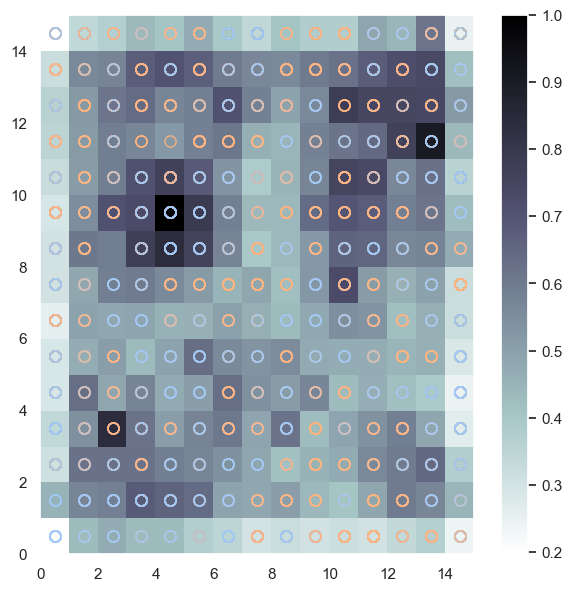

In [36]:
som = MiniSom(x=15, y=15, input_len=X_scaled.shape[1], sigma=1.0, learning_rate=0.5, random_seed=42)
som.random_weights_init(X_scaled)
som.train_random(X_scaled, num_iteration=10000, verbose=True)

plt.figure(figsize=(7,7))
plt.pcolor(som.distance_map().T, cmap='bone_r')
plt.colorbar()
for i, x in enumerate(X_scaled):
    w = som.winner(x)
    plt.plot(w[0]+0.5, w[1]+0.5, 'o', markerfacecolor='None',
             markeredgecolor='C'+str(y_scaled.iloc[i]), markersize=8, alpha=0.6)
plt.show()

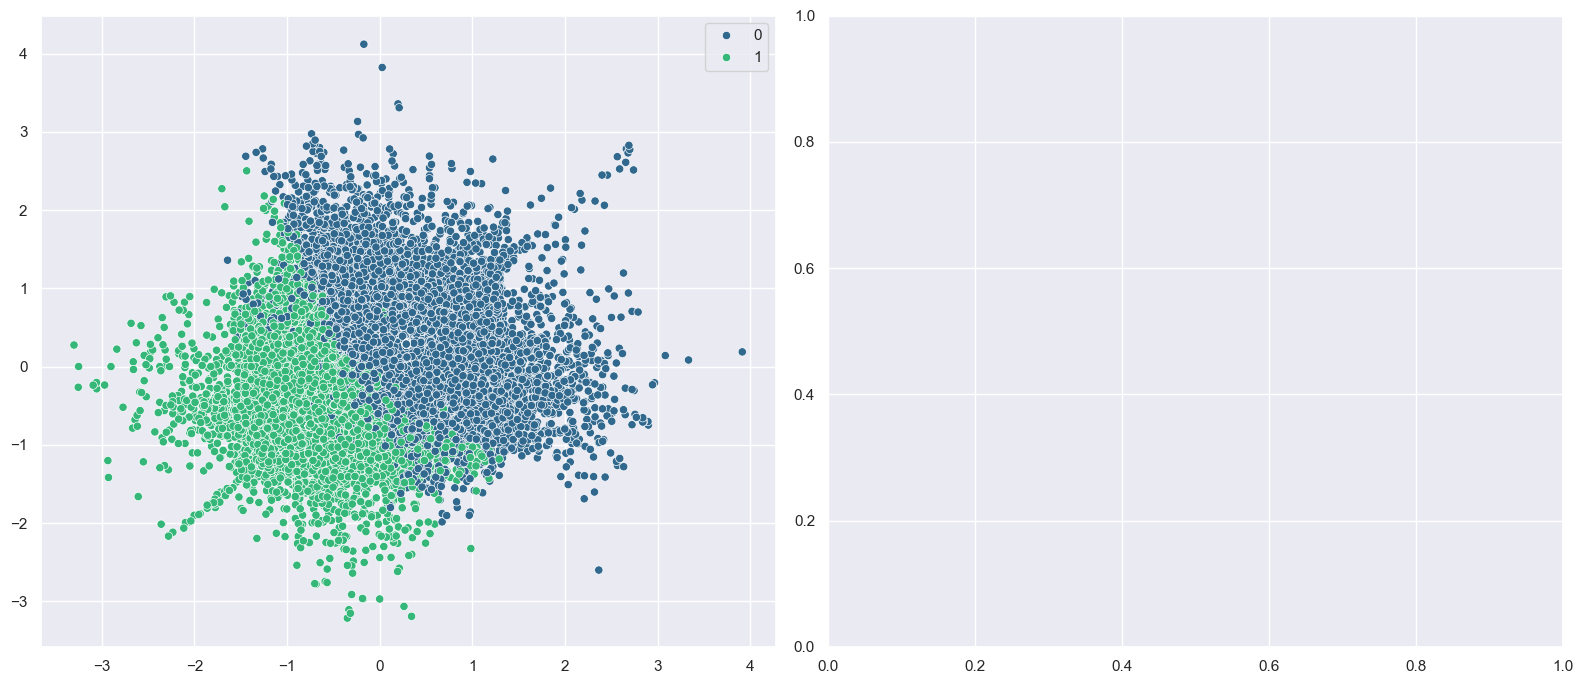

In [37]:
weights = som.get_weights().reshape(-1, 3)
kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(weights)
fig, ax = plt.subplots(1,2,figsize=(16,7))
sns.scatterplot(x=weights[:,0], y=weights[:,1], hue=labels, palette="viridis", ax=ax[0]);
plt.tight_layout()
plt.show();


## 8. Decision Tree

<p align="left">
<img src="img/dtree.png" alt="PCA plot" width="40%" style="float: right; margin-left: 100px; margin-right:100px;">

Model  que aprèn regles de decisió en forma d’arbre per classificar o predir valors.

Objectius:

- Veure a quines característiques  dona més importància l’arbre de decisió.

Limitacions:

- Alta variància: pot sobreajustar fàcilment
- Sensible a petites variacions de les dades
- No generalitza bé sense tècniques de regularització
- Si la precisió del classificador no és prou bona els resultats no tenen perquè ser rellevants

</p>


In [39]:


X_train, X_test, y_train, y_test = train_test_split(X_pca, y_scaled, test_size=0.2, random_state=42)

param = {'criterion':['gini', 'entropy'], 
         'max_depth':[None, 2, 3, 4, 5, 6, 7, 8, 9],
         'min_samples_leaf':[1,2,3,5,10], 
         'splitter': ['best', 'random'], 
         'max_leaf_nodes':[5, 10, 20, 30]}

dt = DecisionTreeClassifier(random_state=42)
dt_bs = BayesSearchCV(dt, param, n_iter=50, cv=5, n_jobs=-1, random_state=42)
dt_bs.fit(X_train, y_train)

BayesSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
              n_jobs=-1, random_state=42,
              search_spaces={'criterion': ['gini', 'entropy'],
                             'max_depth': [None, 2, 3, 4, 5, 6, 7, 8, 9],
                             'max_leaf_nodes': [5, 10, 20, 30],
                             'min_samples_leaf': [1, 2, 3, 5, 10],
                             'splitter': ['best', 'random']})

In [40]:
print(classification_report(y_test, dt_bs.predict(X_test), target_names=['Stable', 'Unstable']))


              precision    recall  f1-score   support

      Stable       0.73      0.75      0.74      1971
    Unstable       0.70      0.67      0.68      1691

    accuracy                           0.71      3662
   macro avg       0.71      0.71      0.71      3662
weighted avg       0.71      0.71      0.71      3662



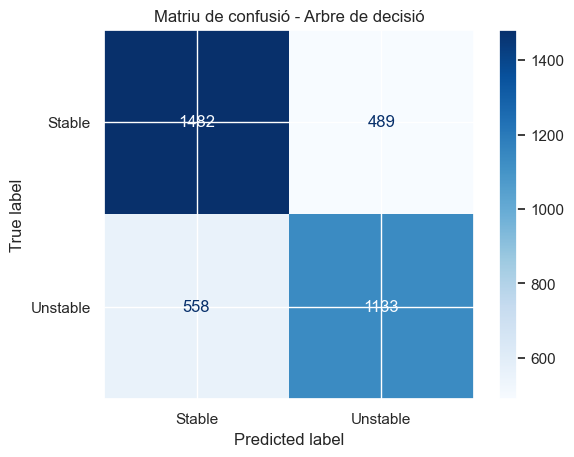

In [41]:

ConfusionMatrixDisplay.from_estimator(dt_bs, X_test, y_test, display_labels=['Stable', 'Unstable'], cmap='Blues');
plt.title("Matriu de confusió - Arbre de decisió")
plt.show()

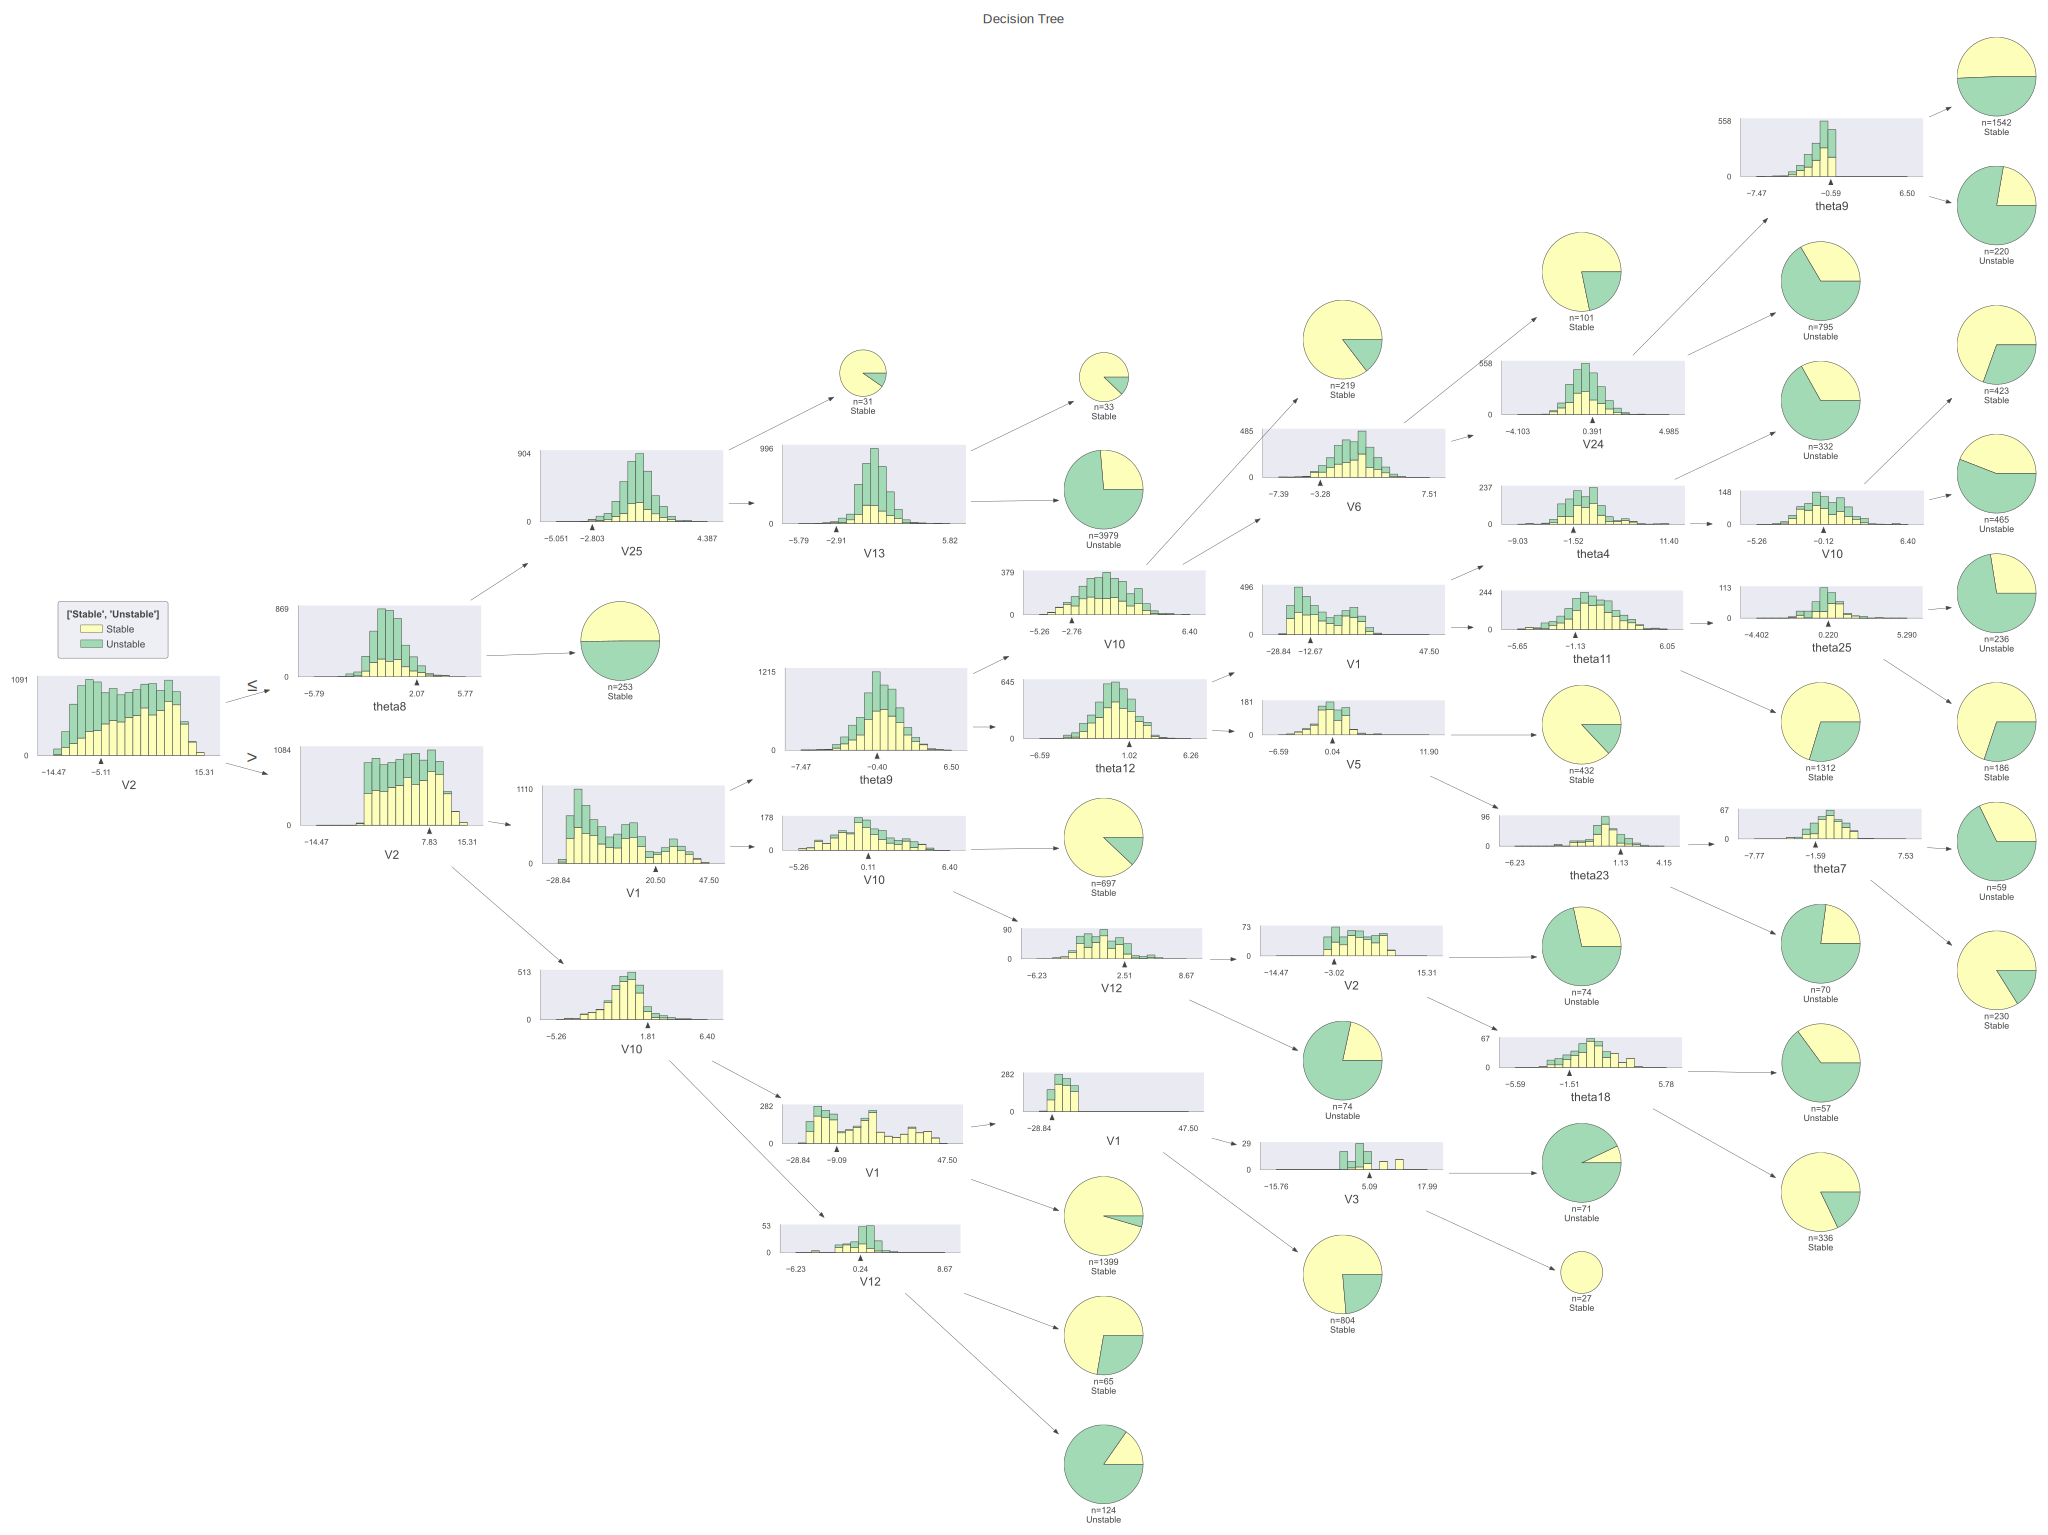

In [42]:
v_model = dtreeviz.model(
    dt_bs.best_estimator_,
    X_train= X_train,
    y_train= y_train,
    target_name=['Stable', 'Unstable'],
    feature_names = [c for c in X_final.columns],
    class_names=['Stable', 'Unstable']  
)
v_model.view(scale=1.5, title="Decision Tree", orientation='LR')

## 9. Gradient Boosting

<p align="left">
<img src="img/gradboost.png" alt="PCA plot" width="40%" style="float: right; margin-left: 100px; margin-right:100px;">

Similar a Decision Tree, construeixen arbres seqüencialment, cada un intentant corregir els errors del precedent.

Objectius:

- Veure a quines característiques  dona més importància l’arbre de decisió.

Limitacions:

- Sensible als hiperparàmetres
- Eficiencia
- Pot sobreajustar

</p>

> [!WARNING]
> Actualment gradient boosting triga una barbaritat de temps :( 

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
param = {
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'max_features': [None, 'sqrt', 'log2']
}

gb = GradientBoostingClassifier(random_state=42)
gb_bs = BayesSearchCV(gb, param, n_iter=10, cv=5, n_jobs=-1, random_state=42)
gb_bs.fit(X_train, y_train)

KeyboardInterrupt: 

In [45]:
print(classification_report(y_test, gb_bs.predict(X_test), target_names=['Stable', 'Unstable']))

AttributeError: 'BayesSearchCV' object has no attribute 'best_estimator_'

In [46]:
ConfusionMatrixDisplay.from_estimator(gb_bs, X_test, y_test, display_labels=['Stable', 'Unstable'], cmap='Blues');
plt.title("Matriu de confusió - Gradient Boosting")
plt.show()

AttributeError: 'BayesSearchCV' object has no attribute 'best_estimator_'

In [47]:
desc = gb_bs.best_estimator_.feature_importances_
feature_importances = pd.DataFrame({'Feature': X_final.columns, 'Importance': desc}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12,8))
sns.barplot(data=feature_importances.head(20), x='Importance', y='Feature')
plt.title("Importància de les característiques - Gradient Boosting")
plt.show()


AttributeError: 'BayesSearchCV' object has no attribute 'best_estimator_'

## 10. FP-Growth


<p align="left">
<img src="img/fpgrowth.png" alt="PCA plot" width="35%" style="float: right; margin-left: 100px; margin-right:100px;">

Es basa en extreure regles de tipus “si X₁, X₂, … → Z” amb els valors descretitzats. 

Models com Gradient Boosting o models especialitzats com RuleFit o CN2 Rule Induction serveixen per crear les regles inicials.

Objectius:

- Trobar conjunts d’ítems freqüents i regles d’associació

Limitacions:

- Pot consumir molta memòria si hi ha molts ítems únics
- Crear les regles inicials pot ser costos 
- No captura dependències temporals o seqüencials
- Resultats difícils d’interpretar amb molts patrons freqüents

</p>

In [48]:
from mlxtend.frequent_patterns import fpgrowth, association_rules
from mlxtend.preprocessing import TransactionEncoder

labels = ['low', 'mid', 'high']
df_discretized = X_final.copy()

for col in df_discretized.columns:
    min_val = df[col].min()
    max_val = df[col].max()
    bins = [min_val - 1e-6, 
            min_val + (max_val - min_val) / 3,
            min_val + 2 * (max_val - min_val) / 3,
            max_val + 1e-6]
    df_discretized[col] = pd.cut(df[col], bins=bins, labels=labels)

df_discretized.head()

V1 theta1    V2 theta2    V3 theta3    V4 theta4    V5 theta5  ...  \
46    high   high  high   high  high   high   mid   high   mid   high  ...   
789   high   high  high   high  high   high  high   high  high   high  ...   
1599  high   high  high   high  high   high  high   high  high   high  ...   
1600  high   high  high   high  high   high  high   high  high   high  ...   
1601  high   high  high   high  high   high  high   high  high   high  ...   

     QL114 PL115 QL115 PL117 QL117 PL118 QL118 P_GFOL31 Q_GFOL31 Sn_GFOL31  
46     low   low   low   low   low   low   low      NaN      NaN       NaN  
789    low   low   low   low   low   low   low      NaN      NaN       NaN  
1599   low   low   low   low   low   low   low      NaN      NaN       NaN  
1600   low   low   low   low   low   low   low      NaN      NaN       NaN  
1601   low   low   low   low   low   low   low      NaN      NaN       NaN  

[5 rows x 609 columns]

In [49]:
te = TransactionEncoder()
te_ary = te.fit(df_discretized).transform(df_discretized)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

fpgrowth_rules = fpgrowth(df_encoded, min_support=0.01, use_colnames=True)
rules = association_rules(fpgrowth_rules, metric="confidence", min_threshold=0.5)
print(rules)




  antecedents consequents  antecedent support  consequent support   support  \
0         (_)         (G)            0.010924            0.010924  0.010924   
1         (G)         (_)            0.010924            0.010924  0.010924   

   confidence   lift  representativity  leverage  conviction  zhangs_metric  \
0         1.0  91.54               1.0  0.010805         inf            1.0   
1         1.0  91.54               1.0  0.010805         inf            1.0   

   jaccard  certainty  kulczynski  
0      1.0        1.0         1.0  
1      1.0        1.0         1.0  
